In [ ]:
import torch as t
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets.voc import VOCSegmentation
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  #imagenet_stats
])

# voc_dataset = VOCSegmentation(
#     root='./',
#     image_set='trainval',
#     download=True,
#     transform=transform)

In [ ]:
!ls -all

total 16
drwxr-xr-x 1 root root 4096 Jun 13 17:32 .
drwxr-xr-x 1 root root 4096 Jun 14 21:46 ..
drwxr-xr-x 4 root root 4096 Jun 13 17:31 .config
drwxr-xr-x 1 root root 4096 Jun 13 17:32 sample_data


In [ ]:
!tar -xvf VOCtrainval_11-May-2012.tar

tar: VOCtrainval_11-May-2012.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
path = "./VOCdevkit/VOC2012/"

VOC2012 dataset

In [ ]:
batch_size = 8
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform)
val_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [ ]:
def visualize(dataset):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    for i in range(3):
        image, label = dataset[i]
        axs[0][i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axs[0][i].set_title(image.size())
        axs[0][i].axis("off")
        axs[1][i].imshow(label, cmap='gray')
        axs[1][i].set_title(label.size)
        axs[1][i].axis("off")
    plt.tight_layout()
    plt.show()

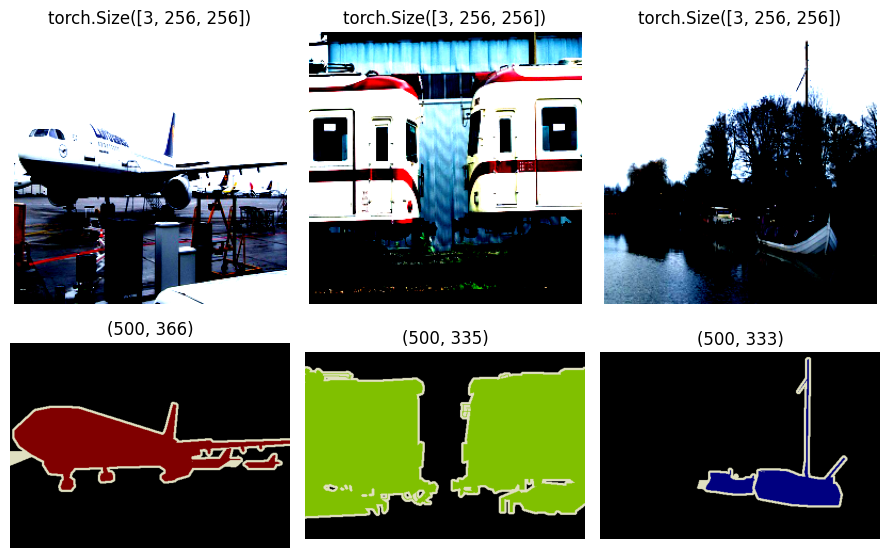

In [ ]:
visualize(val_dataset)

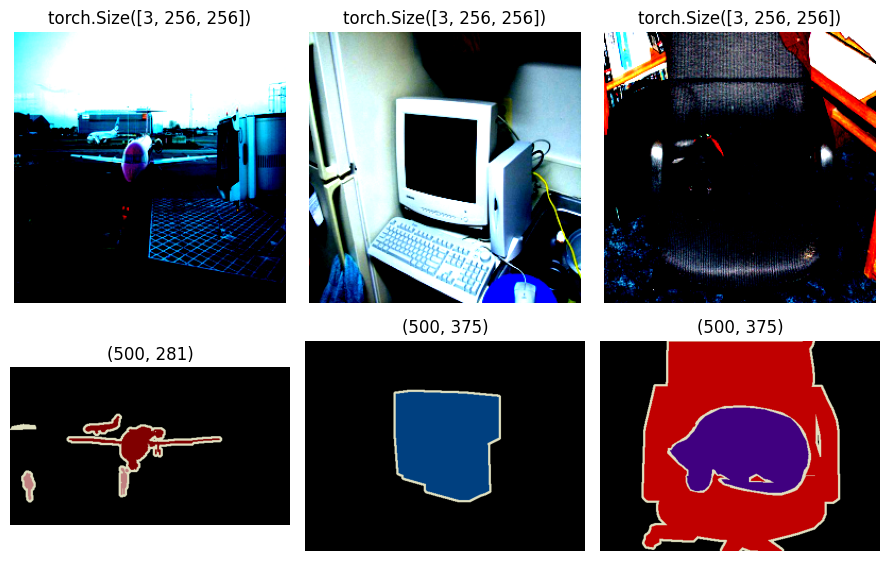

In [ ]:
visualize(train_dataset)

In [ ]:
class Encoder(t.nn.Module):
    def __init__(self, num_classes):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.aspp = aspp(2048, 256, [6, 12, 18])
        self.upsample1 = t.nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv2 = t.nn.Conv2d(2048, 256, kernel_size=1)
        self.upsample2 = t.nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv3 = t.nn.Conv2d(1280, 256, kernel_size=1)
        self.upsample3 = t.nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.classifier = t.nn.Sequential(
            t.nn.Conv2d(512, 256, kernel_size=1),
            t.nn.BatchNorm2d(256),
            t.nn.ReLU(inplace=True),
            t.nn.Conv2d(256, num_classes, kernel_size=1),
            t.nn.BatchNorm2d(num_classes),
            t.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        enc = self.layer4(x)
        x = self.aspp(enc)
        enc = self.upsample1(enc)
        enc = self.conv2(enc)
        x = self.upsample2(x)
        x = self.conv3(x)
        x = t.cat([x, enc], dim=1)
        x = self.upsample3(x)
        out = self.classifier(x)
        return out

In [ ]:
class aspp(t.nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(aspp, self).__init__()
        self.conv1 = t.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = t.nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=atrous_rates[0], padding=atrous_rates[0])
        self.conv3 = t.nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=atrous_rates[1], padding=atrous_rates[1])
        self.conv4 = t.nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=atrous_rates[2], padding=atrous_rates[2])
        self.conv5 = t.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = t.nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(x)
        conv3_out = self.conv3(x)
        conv4_out = self.conv4(x)
        image_level_features = self.pool(x)
        image_level_features = t.nn.functional.interpolate(image_level_features, size=x.size()[2:], mode='bilinear', align_corners=False)
        image_level_features = self.conv5(image_level_features)
        out = t.cat((conv1_out, conv2_out, conv3_out, conv4_out, image_level_features), dim=1)
        return out

In [ ]:
class gcm(t.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(gcm, self).__init__()
        self.global_pooling = t.nn.AdaptiveAvgPool2d(1)
        self.conv1x1 = t.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        global_features = self.global_pooling(x)
        global_features = self.conv1x1(global_features)
        global_features = t.nn.functional.interpolate(global_features, size=(x.size()[2:]), mode='bilinear', align_corners=False)
        return global_features

In [ ]:
aspp(2048, 256, [6, 12, 18])

aspp(
  (conv1): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
  (conv3): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12))
  (conv4): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(18, 18), dilation=(18, 18))
  (conv5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): AdaptiveAvgPool2d(output_size=1)
)

In [ ]:
class Decoder(t.nn.Module):
    def __init__(self, num_classes=21):
        super(Decoder, self).__init__()
        self.conv1 = t.nn.Conv2d(256, 128, kernel_size=1)
        self.upsample2 = t.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = t.nn.Conv2d(304, 256, kernel_size=3, padding=1)
        self.upsample3 = t.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv3 = t.nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.upsample4 = t.nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.conv4 = t.nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x, encoder_output):
        x = self.aspp(x)
        x = self.upsample1(x)
        input_b = encoder_output
        input_b = self.conv1(input_b)
        x = t.cat([x, input_b], dim=1)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)
        x = self.upsample3(x)
        x = self.conv4(x)
        x = self.upsample4(x)
        return x

By default, the VOCSegmentation dataset from torchvision does not resize the labels (masks) when using the transforms.Resize operation.


The authors dealt with images of different sizes by adopting an approach called "asymmetric non-local operation" (ANL) and "global context module" (GCM). These components enable the model to effectively capture long-range dependencies and global contextual information, regardless of the input image size.

The ANL operation is applied to each convolutional layer in the model. It leverages dilated convolutions with different dilation rates to capture multi-scale contextual information. By using dilated convolutions, the receptive field of each convolutional layer is expanded, allowing the model to capture contextual information from larger image regions. This approach ensures that the model can handle images of different sizes and effectively capture global context.

The GCM is a module that is applied to the output of the encoder network. It aggregates global context information by using a global pooling operation followed by a series of convolutional layers. This module enables the model to capture global information from the entire image, regardless of its size.

By incorporating these components into the model architecture, the paper addresses the challenge of handling images of different sizes and ensures that the model can effectively capture global context and long-range dependencies, leading to improved semantic image segmentation performance.

In [ ]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
# Hyperparameters
num_classes = 21
batch_size = 4
num_epochs = 10
learning_rate = 0.001

In [ ]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [transforms.functional.resize(item[1], size=(256, 256)) for item in batch]
    labels = [transforms.functional.to_tensor(label).expand(3, -1, -1) for label in labels]
    return t.stack(images, dim=0), t.stack(labels, dim=0)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
model = Encoder(21).to(device)
criterion = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
Decoder()

Decoder(
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (upsample2): Upsample(scale_factor=2.0, mode='bilinear')
  (conv2): Conv2d(304, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample4): Upsample(scale_factor=4.0, mode='bilinear')
  (conv4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
from torchsummary import summary
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
model.load_state_dict(t.load("model_dlp3.pth"))

<All keys matched successfully>

In [ ]:
def create_mask(labels):
    mask = t.zeros_like(labels)
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            for k in range(labels.shape[2]):
                mask[i][j][k] = (labels[i][j][k] > 0).float()
    return mask.int()

In [ ]:
train_loss=[]
valid_loss=[]
for epoch in range(10):
    model.train()
    total_loss = 0
    total_samples = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels[:, 0, :, :].long().to(device)
        outputs = model(images)
        labels = t.nn.functional.one_hot(labels, num_classes).permute(0, 3, 1, 2).float()
        mask=create_mask(labels)
        loss = criterion(outputs[mask], labels[mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
    average_loss = total_loss / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:}")
    train_loss.append(average_loss)
    # Validation
    model.eval()
    with t.no_grad():
        total_val_loss = 0
        total_val_samples = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels[:, 0, :, :].long().to(device)
            outputs = model(images)
            labels = t.nn.functional.one_hot(labels, num_classes).permute(0, 3, 1, 2).float()
            mask=create_mask(labels)
            val_loss = criterion(outputs[mask], labels[mask])
            total_val_loss += val_loss.item() * images.size(0)
            total_val_samples += images.size(0)
        average_val_loss = total_val_loss / total_val_samples
        print(f"Validation Loss: {average_val_loss:}")
        valid_loss.append(average_val_loss)

In [ ]:
t.save(model.state_dict(),"model_dlp3.pth")

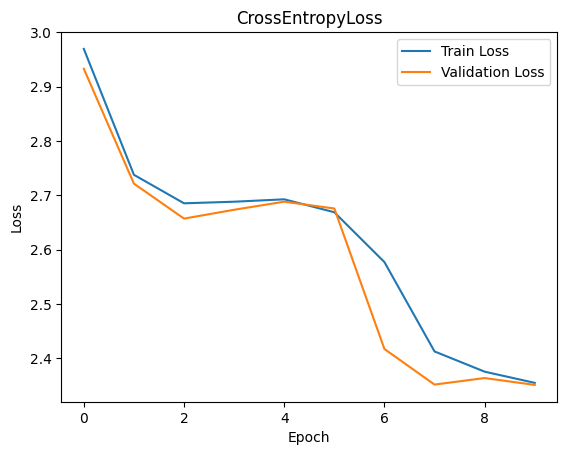

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CrossEntropyLoss')
plt.legend()
plt.show()

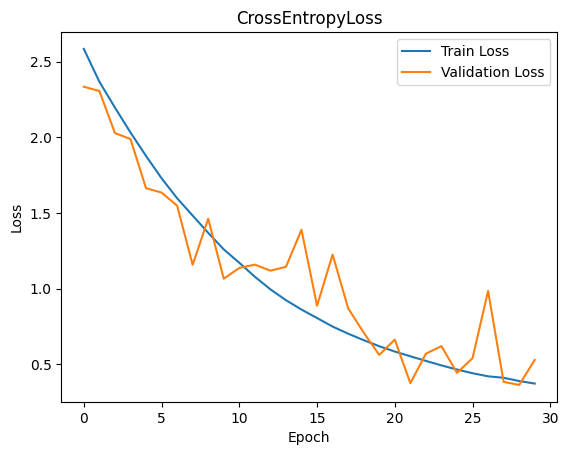

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CrossEntropyLoss')
plt.legend()
plt.show()

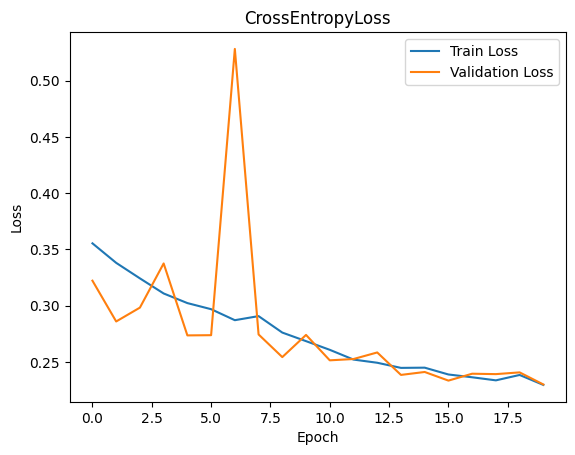

In [ ]:
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CrossEntropyLoss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
outputs_np = outputs.argmax(dim=1).detach().cpu().numpy()
labels_np = labels.argmax(dim=1).detach().cpu().numpy()

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(labels_np.flatten(), outputs_np.flatten(), average='weighted', zero_division=1)

In [ ]:
precision

0.9887300846428735

In [ ]:
recall

0.9886001275510204

In [ ]:
f1

0.9829328668478818

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(outputs_np.reshape(-1),labels_np.reshape(-1))

0.9886001275510204

In [ ]:
def compute_miou(outputs, labels):
    intersection = t.sum(outputs * labels, dim=(1, 2))
    union = t.sum(outputs + labels, dim=(1, 2)) - intersection
    iou = intersection / (union)  # Add a small epsilon to avoid division by zero
    miou = t.mean(iou)
    return miou

model.eval()
total_miou = 0
total_samples = 0

with t.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels[:, 0, :, :].long().to(device)
        outputs = model(images)
        miou = compute_miou(outputs.argmax(dim=1), labels)
        total_miou += miou.item() * images.size(0)
        total_samples += images.size(0)

average_miou = total_miou / total_samples
print(f"mIoU%: {average_miou*100}")

mIoU%: 54.816957352344865


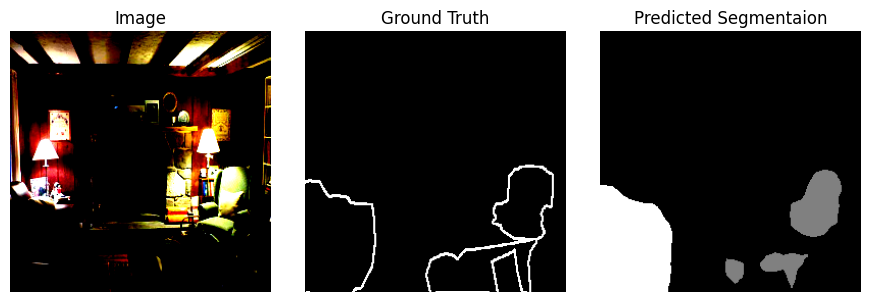

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
axs[0].imshow(np.transpose(images[0].detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Image")
axs[0].axis("off")
axs[1].imshow(labels[0].detach().cpu().numpy().reshape(256,256), cmap='gray')
axs[1].set_title("Ground Truth")
axs[1].axis("off")
axs[2].imshow(outputs[0].detach().cpu().numpy().reshape(256,256), cmap='gray')
axs[2].set_title("Predicted Segmentaion")
axs[2].axis("off")
plt.tight_layout()
plt.show()

Taking Pretrained deeplabv3 based on resnet50 trained on COCO data, freezing earlier layers, changing the classifier at the end and triaining those only.

In [62]:
model = t.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [53]:
model.classifier[-1] = t.nn.Conv2d(256, 21, kernel_size=1)

In [55]:
optimizer = t.optim.Adam(model.classifier[-1].parameters(), lr=0.001)

In [63]:
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [59]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks[:, 0, :, :].long().to(device)
        # Forward pass
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")

Epoch [1/10], Loss: 1.29401719708586
Epoch [2/10], Loss: 0.7321989146249542
Epoch [3/10], Loss: 0.7157096949919977
Epoch [4/10], Loss: 0.7138522304798085
Epoch [5/10], Loss: 0.7069895701493071
Epoch [6/10], Loss: 0.7056817649329294
Epoch [7/10], Loss: 0.7114563140549947
Epoch [8/10], Loss: 0.7017428544375415
Epoch [9/10], Loss: 0.698712884402666
Epoch [10/10], Loss: 0.6995321670190884


In [75]:
model.eval()
total_miou = 0
total_samples = 0

with t.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels[:, 0, :, :].long().to(device)
        outputs = model(images)
        miou = compute_miou(outputs["out"].argmax(dim=1), labels)
        total_miou += miou.item() * images.size(0)
        total_samples += images.size(0)

average_miou = total_miou / total_samples
print(f"mIoU%: {average_miou*100}")

mIoU%: 64.64829290526089


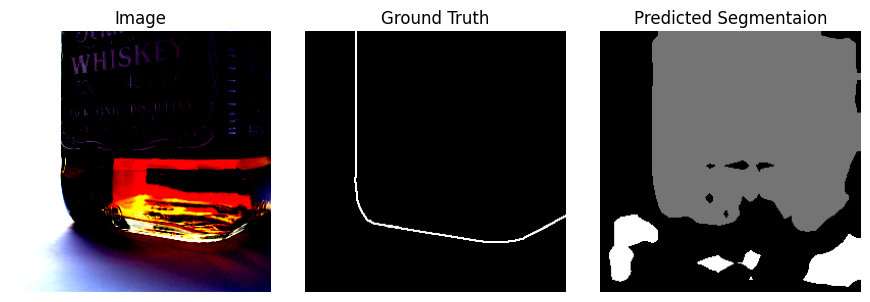

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
axs[0].imshow(np.transpose(images[0].detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Image")
axs[0].axis("off")
axs[1].imshow(labels[0].detach().cpu().numpy().reshape(256,256), cmap='gray')
axs[1].set_title("Ground Truth")
axs[1].axis("off")
axs[2].imshow(outputs["out"].argmax(dim=1)[0].detach().cpu().numpy().reshape(256,256), cmap='gray')
axs[2].set_title("Predicted Segmentaion")
axs[2].axis("off")
plt.tight_layout()
plt.show()